In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import polynomial as poly
import scipy.signal



%matplotlib widget


- Refrence plane at end of chode cable
- chode cable -> patch pannel -> 1012 -> MC 1r5+ -> MC 3dB att -> MC 1dB att -> MC30dB att -> pink cable -> MC 1dB att -> shp1200+ LPF
  - Not exactly the amp chain! may require corrections. Filter is different
- 10k avg
- $2^{18}$ pt fft

Notes:
touching the terminator and taking a scan moves the mean by about 0.1dB (room temp term with 30dB attenuator that's 1.15e-12W to 1.18e-12W)


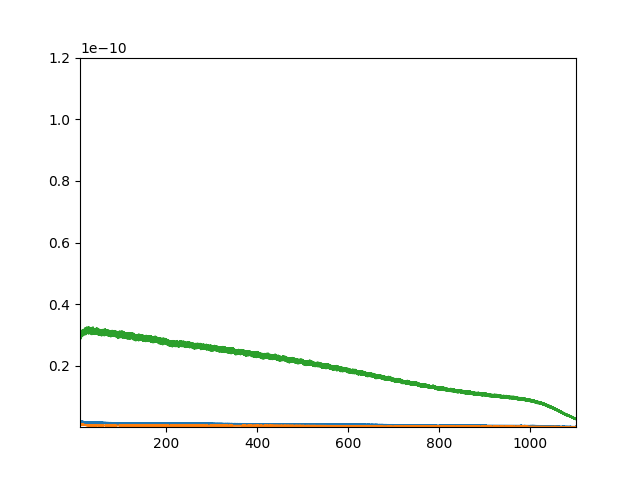

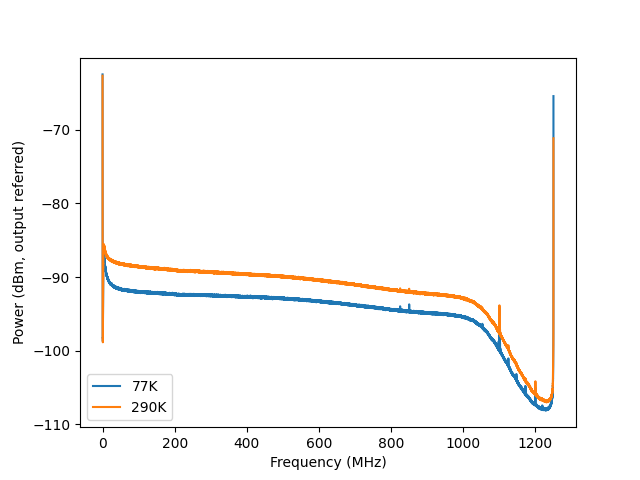

In [6]:
#load data
freqs = np.linspace(0, 1250, 2**17)

#term right on cable
term_roomTemp = np.load('./data_gitignore/50Ohm_roomtemp.npy', allow_pickle = True).item()['chBSpec_W']
cryo_roomTemp = np.load('./data_gitignore/cryocable_50Ohms_roomtemp.npy', allow_pickle = True).item()['chBSpec_W'] 
cryo_LN2 = np.load('./data_gitignore/cryocable_50Ohms_LN2.npy', allow_pickle = True).item()['chBSpec_W'] 
#cryo_LN2_wait = np.load('./data_gitignore/cryocable_50Ohms_LN2_wait.npy', allow_pickle = True).item()['chBSpec_W'] #see when it hits 77K
#NS_15V = np.load('./data_gitignore/31dBSource_15p00V.npy', allow_pickle = True).item()['chBSpec_W'] 
#NS_0V = np.load('./data_gitignore/31dBSource_0V.npy', allow_pickle = True).item()['chBSpec_W'] 
NS16_0V = np.load('./data_gitignore/16dBSource_0V.npy', allow_pickle = True).item()['chBSpec_W'] 
NS16_28V = np.load('./data_gitignore/16dBSource_28V.npy', allow_pickle = True).item()['chBSpec_W'] 

plt.close('all')
plt.figure()
#plt.plot(freqs, term_roomTemp[1:])
plt.plot(freqs, cryo_roomTemp[1:])
plt.plot(freqs, cryo_LN2[1:])
plt.plot(freqs, NS16_28V[1:])
plt.ylim(.1e-12,1.2e-10)
plt.xlim(10, 1100)

plt.figure()
#plt.plot(freqs, term_roomTemp[1:])
plt.plot(freqs, 10*np.log10(1000*cryo_LN2[1:]), label = "77K")
plt.plot(freqs, 10*np.log10(1000*cryo_roomTemp[1:]), label = "290K")
#plt.plot(freqs, 10*np.log10(1000*NS_15V[1:]))
#plt.plot(freqs, 10*np.log10(1000*NS16_0V[1:]), label = "16dB NS, 0V")
#plt.plot(freqs, 10*np.log10(1000*NS16_28V[1:]), label = "16dB NS, 28V")
#plt.ylim(-95,-65)
#plt.xlim(10, 1100)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm, output referred)')
plt.legend()

temp of source (16.1dB ENR) 12104.028056319272 K
rise over run gain :40.337413867027706dB
[  14632.30101682 2302093.72336871]
gain: 41.653126268998136 dB
Noise Temp: 157.3295765800444


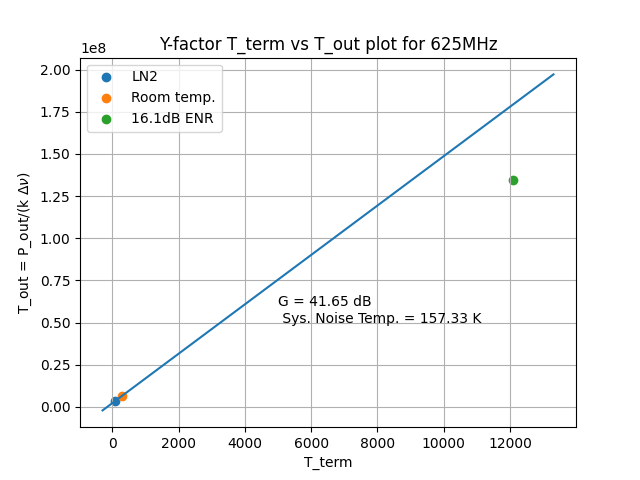

In [7]:
#test method at only 625MHz before doing it on the full array
# I don't think the 16.1dB ENR source works, I get reasonable results using LN2 and room temp

k = 1.380649e-23  # Boltzmann constant in J/K
B = 2.5e9/2**18 #bandwidth, Hz/bin
T0 = 290  # Standard temperature in K

RT      = cryo_roomTemp[2**16]/(k*B)
cold    = cryo_LN2[2**16]/(k*B)
hot     = NS16_28V[2**16]/(k*B)

T_hot = T0*(10**(16.1/10) + 1) #500MHz ENR from data sheet
print(f'temp of source (16.1dB ENR) {T_hot} K')
temps = {"RT" : 294.4, "cold":77.3,  "hot": T_hot}
temp_array = np.array([temps['RT'],temps['cold']])
#temp_array = np.array([temps['RT'], temps['cold'], temps['hot']])

print(f'rise over run gain :{10*np.log10((hot-RT)/(T_hot-294))}dB')

pows = [RT, cold]

fitParams = np.polyfit(temp_array, pows, 1)
print(fitParams)
print(f'gain: {10*np.log10(fitParams[0])} dB')
print(f'Noise Temp: {fitParams[1]/fitParams[0]}')

xpts = np.linspace(-300, T_hot*1.1, 1000)

plt.close('all')
plt.figure()
plt.title('Y-factor T_term vs T_out plot for 625MHz')
plt.scatter(temps['cold'], cold, label = 'LN2')
plt.scatter(temps['RT'], RT, label = 'Room temp.')
plt.scatter(temps['hot'], hot, label = '16.1dB ENR')
plt.plot(xpts, fitParams[0]*xpts + fitParams[1])
plt.xlabel("T_term")
plt.ylabel(f"T_out = P_out/(k $\\Delta \\nu$)")
plt.text(5000,0.5e8, f'G = {round(10*np.log10(fitParams[0]),2)} dB \n Sys. Noise Temp. = {round(fitParams[1]/fitParams[0],2)} K ')
plt.legend()
plt.grid()

/tmp/ipykernel_478660/125888150.py:25: RuntimeWarning: invalid value encountered in log10
  plt.plot(freqs, 10*np.log10(G))


NameError: name 'noiseTemp_plotting' is not defined

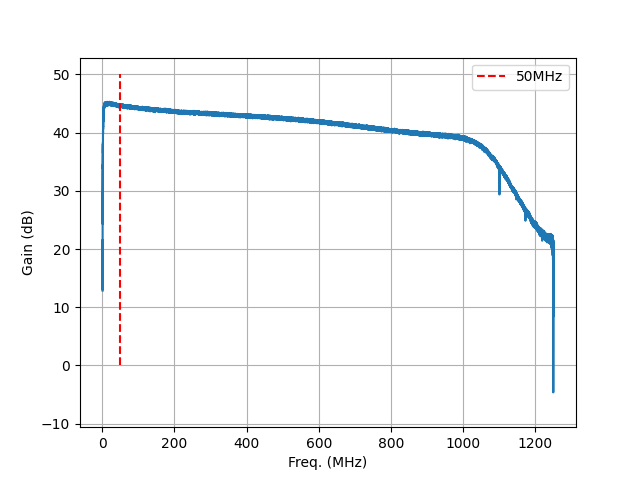

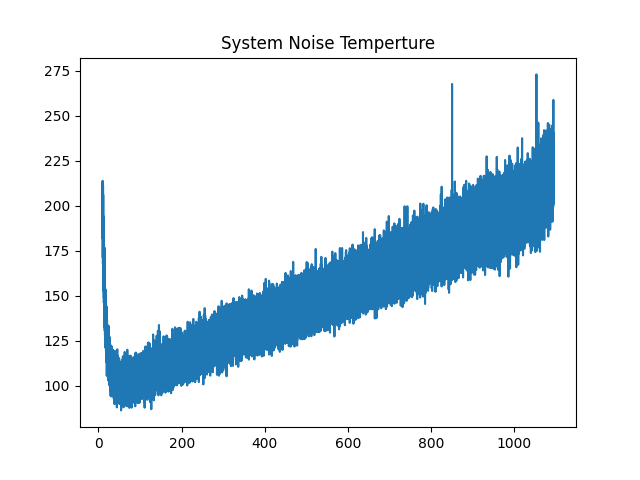

In [8]:
#Gain and NF as a function of frequency

RT      = cryo_roomTemp/(k*B)
cold    = cryo_LN2/(k*B)
hot     = NS16_28V/(k*B)

temps = {"RT" : 294.4, "cold":77.3}
temp_array = np.array([temps['RT'],temps['cold']])

pows = np.vstack((RT, cold))
fitParams = np.polyfit(temp_array, pows, 1)

G   = fitParams[0,1:] # gain as measured by Y factor (including extra attenuator)

xpts = np.linspace(-300, T_hot*1.1, 1000)

### slow! uncomment!!! ###
#noiseTemp_plotting = scipy.signal.medfilt((fitParams[1,1:]/fitParams[0,1:]), 1001)[2**10:-2**14]

#save noise temp
#np.save('./noiseTempMeaurement_K_fitToRTandLN2_10_14_23', (fitParams[1,1:]/fitParams[0,1:]))

plt.close('all')
plt.figure()
plt.plot(freqs, 10*np.log10(G))
plt.plot((50,50),(0,50), 'r--', label = '50MHz')
plt.xlabel("Freq. (MHz)")
plt.ylabel("Gain (dB)")
plt.grid(True)

plt.legend()

plt.figure()
plt.title('System Noise Temperture')
plt.plot(freqs[2**10:-2**14],(fitParams[1,1:]/fitParams[0,1:])[2**10:-2**14], label = 'Raw')
plt.plot(freqs[2**10:-2**14],noiseTemp_plotting, label = 'Median Filter (1001 bins)')
#plt.plot((50,50),(70,300), 'r--', label = '50MHz')
plt.xlabel("Frequency (MHz)")
plt.ylabel(f"T_out = P_out/(k $\\Delta \\nu$)")
extraticks = [50, 30]
#plt.xticks(list(plt.xticks()[0]) + extraticks)
plt.xlim(20,350)
plt.ylim(85,155)
plt.legend()
plt.grid(True)


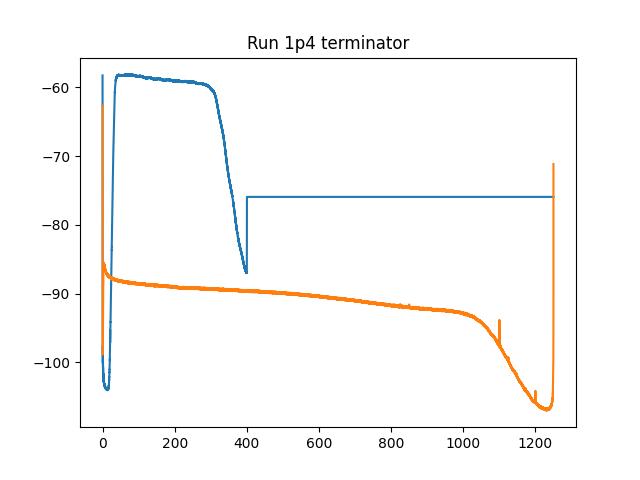

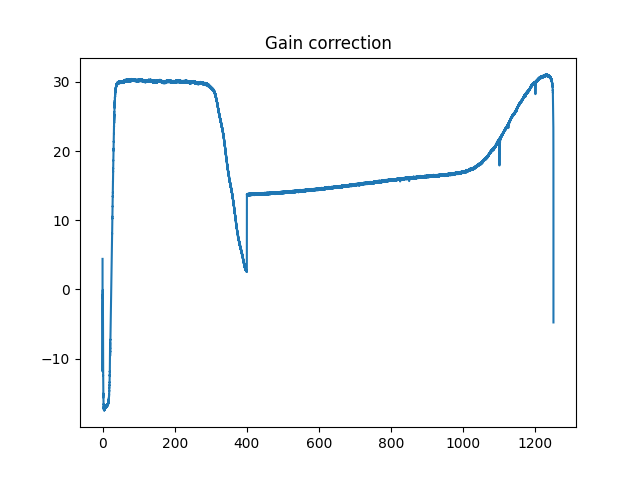

In [9]:
# the NF test set up used an extra 30dB attenuator to prevent clipping, and a different anti aliasing filter. Correct for this by taking terminator scans 
# with actual run1A and 1B amp chains. Correct RBW to match data taken
 
run1p4Term      = np.load('./data_gitignore/run1p4_term_avg.npy')[1:] * ((2.5e9/2**18)/(800e6/2**24))
run1p4Freqs    = np.linspace(0,400,2**23)

run1p4Term_interp = np.interp(freqs,run1p4Freqs, run1p4Term)

gainCorrection =  run1p4Term_interp / cryo_roomTemp[1:]

#10*np.log10(run1p4Term_interp*1000)

plt.close('all')
plt.figure()
plt.title('Run 1p4 terminator')
plt.plot(freqs, 10*np.log10(run1p4Term_interp*1000))
#plt.plot(freqs, 10*np.log10(run1p4Term_interp* ((2.5e9/2**18)/(800e6/2**24))*1000))
plt.plot(freqs, 10*np.log10(cryo_roomTemp[1:]*1000))
#plt.plot(freqs, 10*np.log10(cryo_roomTemp[1:]*1000) + 10*np.log10(gainCorrection))

plt.figure()
plt.title('Gain correction')
plt.plot(freqs, 10*np.log10(gainCorrection))

/tmp/ipykernel_478660/3609608519.py:17: RuntimeWarning: invalid value encountered in log10
  plt.plot(freqs, 10*np.log10(G*gainCorrection), label = 'Raw')


NameError: name 'gainPlotting' is not defined

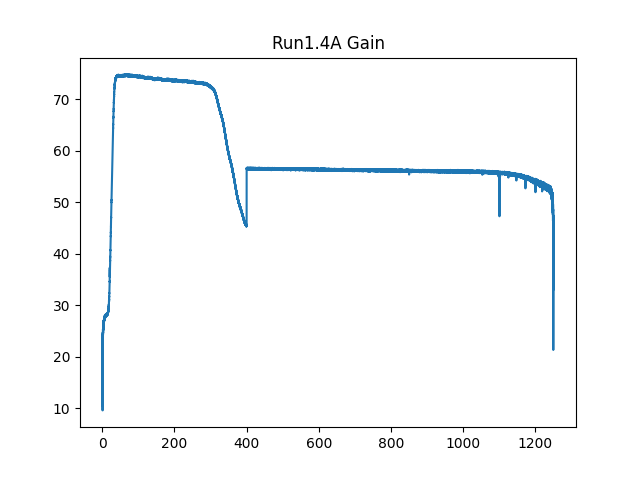

In [10]:
#compare to tracking gen. gain measurement made ~may 2023
#see lab book p18 for details

freqsTG         = np.load('../gainAndNf/data/calibration_5_8_23.npy')[:,0]/1e6
calibrationTG   = np.load('../gainAndNf/data/calibration_5_8_23.npy')[:,1]

filename        = '1012E_amp11p16V_psu_12p93V_zklA_rfPreOff_5_8_23.npy'

dataTG          = np.load('../gainAndNf/data/' + filename)[:,1]
dataCal         = dataTG - calibrationTG

### slow! uncomment!!! ###
#gainPlotting    = scipy.signal.medfilt(10*np.log10(G*gainCorrection), 1001)[2**10:-2**14]

plt.close('all')
plt.figure()
plt.title('Run1.4A Gain')
plt.plot(freqs, 10*np.log10(G*gainCorrection), label = 'Raw')
plt.plot(freqs[2**10:-2**14],gainPlotting, label = 'Median Filter (1001 bins)')
plt.plot(freqsTG, dataCal, label = 'track gen. (may 2023)')
#plt.plot((50,50),(0,80), 'r--', label = '50MHz')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Gain (dB)")
plt.grid(True)
#plt.legend()
plt.xlim(30,320)
plt.ylim(71,75)

plt.figure()
plt.title('Run1.4A NF')
plt.plot(freqs[2**10:-2**14],(fitParams[1,1:]/fitParams[0,1:])[2**10:-2**14])
#plt.plot((50,50),(70,300), 'r--', label = '50MHz')
plt.xlabel("Freq. (MHz)")
plt.ylabel(f"T_out = P_out/(k $\\Delta \\nu$)")
plt.legend()
plt.grid(True)

/tmp/ipykernel_478660/3808825158.py:6: RuntimeWarning: invalid value encountered in log10
  plt.plot(freqs,10*np.log10(run1p4Term_interp*1000)- 10*np.log10(G*gainCorrection) - 10*np.log10(2.5e9/2**18) -10*np.log10((fitParams[1,1:]/fitParams[0,1:])/T0 + 1))


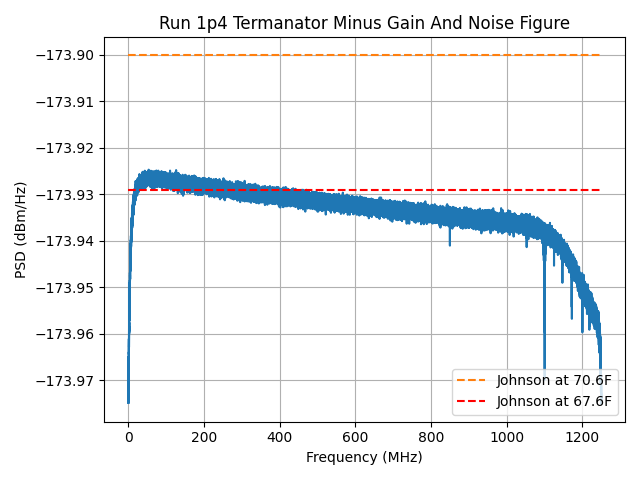

In [11]:
#confirm we get johnson 

plt.close('all')

plt.title('Run 1p4 Termanator Minus Gain And Noise Figure')
plt.plot(freqs,10*np.log10(run1p4Term_interp*1000)- 10*np.log10(G*gainCorrection) - 10*np.log10(2.5e9/2**18) -10*np.log10((fitParams[1,1:]/fitParams[0,1:])/T0 + 1))
plt.plot((0,1250),(-173.9, -173.9), '--', label = 'Johnson at 70.6F')
plt.plot((0,1250),(-173.929, -173.929), 'r--', label = 'Johnson at 67.6F')
plt.xlabel('Frequency (MHz)')
plt.ylabel('PSD (dBm/Hz)')
plt.tight_layout()
plt.legend(loc = 'lower right')
plt.grid(True)

/tmp/ipykernel_3271953/4159300017.py:4: RuntimeWarning: invalid value encountered in log10
  plt.plot(freqs, 10*np.log10(G*gainCorrection), label = 'Y-factor method')


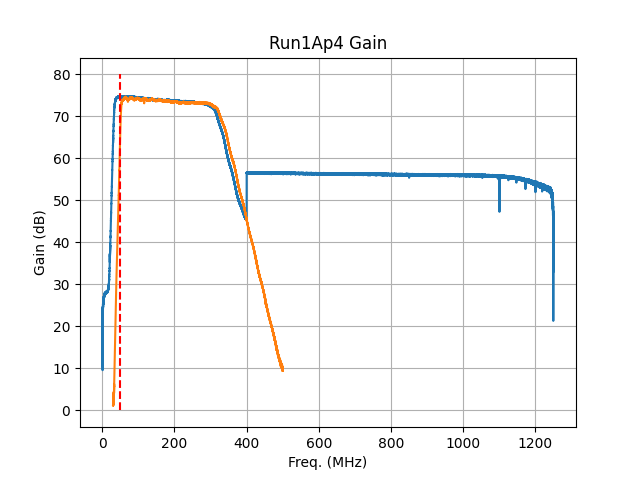

In [8]:
plt.close('all')
plt.figure()
plt.title('Run1Ap4 Gain')
plt.plot(freqs, 10*np.log10(G*gainCorrection), label = 'Y-factor method')
plt.plot(freqsTG, dataCal, label = 'track gen.')
plt.plot((50,50),(0,80), 'r--', label = '50MHz')
plt.xlabel("Freq. (MHz)")
plt.ylabel("Gain (dB)")
plt.grid(True)
